In [1]:
import os
import sys
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import numpy as np

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    
from data_handle import(
    ForexDataClean,
    ForexDataLoad
)

from features import ForexFeauturesExtractor

from plots import ForexPlotter


import warnings
warnings.filterwarnings('ignore')

data = ForexDataLoad(file_path = '../data/xauaud.csv').data

cleaner = ForexDataClean(data = data)
data = cleaner.fast_cleaner()

features = ForexFeauturesExtractor(
    data = data
)

all_features, indicators_data, signals_data, extreme_data = features.extract_all_features()

FOREX DATA LOADER
 Available Fuctions 
1 load_csv 
2 load_from_database
Data loaded successfully!
Shape: (38217, 5)

FOREX DATA CLEANER
 Available Fuctions 
1 remove_duplicates 
2 handle_missing_values 
3 validate_ohlc_integrity 
4 handle_outliers 
5 fast_cleaner
Keep = first and subset = None
Removed 0 duplicate entries
OHLC DATA INTEGRITY VALIDATION
No OHLC integrity violations found
All OHLC values are consistent
Found 1 missing values
 dropped: 1 missing values .
OHLC DATA INTEGRITY VALIDATION
No OHLC integrity violations found
All OHLC values are consistent


In [2]:
import tensorflow as tf
tf.keras.backend.clear_session() 

In [3]:
print(extreme_data.head())

                       close  Label_p5_o1  Label_p5_o2  Label_p5_o3  \
datetime                                                              
2017-04-24 02:00:00  1682.15            0            0            0   
2017-04-24 03:00:00  1689.13            2            2            2   
2017-04-24 04:00:00  1687.68            1            0            0   
2017-04-24 05:00:00  1688.36            2            0            0   
2017-04-24 06:00:00  1687.06            0            0            0   

                     Label_p5_o4  Label_p5_o5  Label_p5_o10  Label_p5_o20  \
datetime                                                                    
2017-04-24 02:00:00            0            0             0             0   
2017-04-24 03:00:00            2            2             2             0   
2017-04-24 04:00:00            0            0             0             0   
2017-04-24 05:00:00            0            0             0             0   
2017-04-24 06:00:00            0        

In [4]:
print(f"\n1 - All Features Shape: {all_features.shape}")
print(f"\n2 - Indicators Data Shape: {indicators_data.shape}")
print(f"\n3 - Signals Data Shape: {signals_data.shape}")
print(f"\n4 - Labels Data Shape: {extreme_data.shape}")


1 - All Features Shape: (38216, 398)

2 - Indicators Data Shape: (38216, 91)

3 - Signals Data Shape: (38216, 273)

4 - Labels Data Shape: (38216, 36)


In [5]:
from models import TimeSeriesAutoencoder

In [6]:
autoencoder = TimeSeriesAutoencoder(
        input_dim=extreme_data.shape[1] - 1,  
        encoding_dim=2,
        learning_rate=0.001
    )

In [7]:
train_data, test_data = autoencoder.prepare_data(
    extreme_data, 
    target_column='close',
    test_size=0.2
)

Training samples: 30572
Test samples: 7644


In [8]:
history = autoencoder.train(epochs=30, batch_size=24, verbose=1)


Epoch 1/30
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3098 - mae: 0.2979 - val_loss: 0.0342 - val_mae: 0.0777
Epoch 2/30
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0561 - mae: 0.1181 - val_loss: 0.0102 - val_mae: 0.0481
Epoch 3/30
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0432 - mae: 0.1023 - val_loss: 0.0059 - val_mae: 0.0343
Epoch 4/30
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0361 - mae: 0.0954 - val_loss: 0.0031 - val_mae: 0.0248
Epoch 5/30
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0364 - mae: 0.0933 - val_loss: 0.0028 - val_mae: 0.0269
Epoch 6/30
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0323 - mae: 0.0883 - val_loss: 0.0155 - val_mae: 0.0428
Epoch 7/30
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0275 - mae: 0.0853 - val_loss: 0.0016 - val_mae: 0.0195
Epoch 8/30
1274/1274 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0254 - mae: 0.0826 - val_loss: 0.0022 - val_mae: 0.0220
Epoch 9/30
1274/1274 ━━━━━━━━━━━━━━━━━━━

In [9]:
labels_data_with_latent = autoencoder.add_latent_features(extreme_data)

In [10]:
metrics = autoencoder.evaluate()
print("\nModel Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")


Model Metrics:
final_training_loss: 0.0158
final_validation_loss: 0.0013
training_reconstruction_error: 0.0013
test_reconstruction_error: 0.0013
generalization_gap: -0.0000


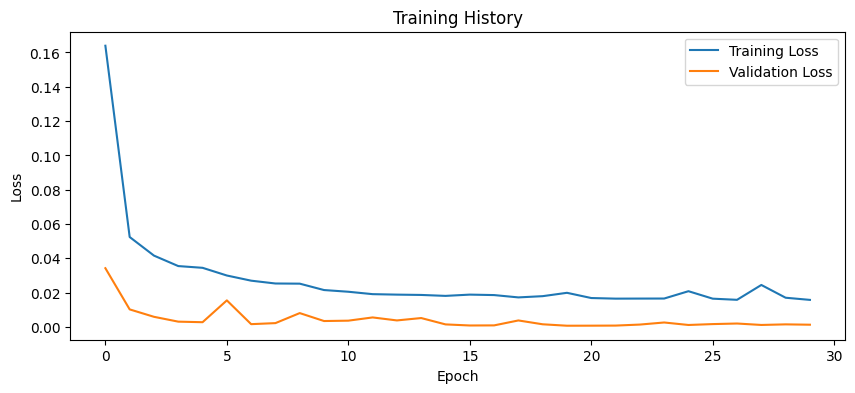

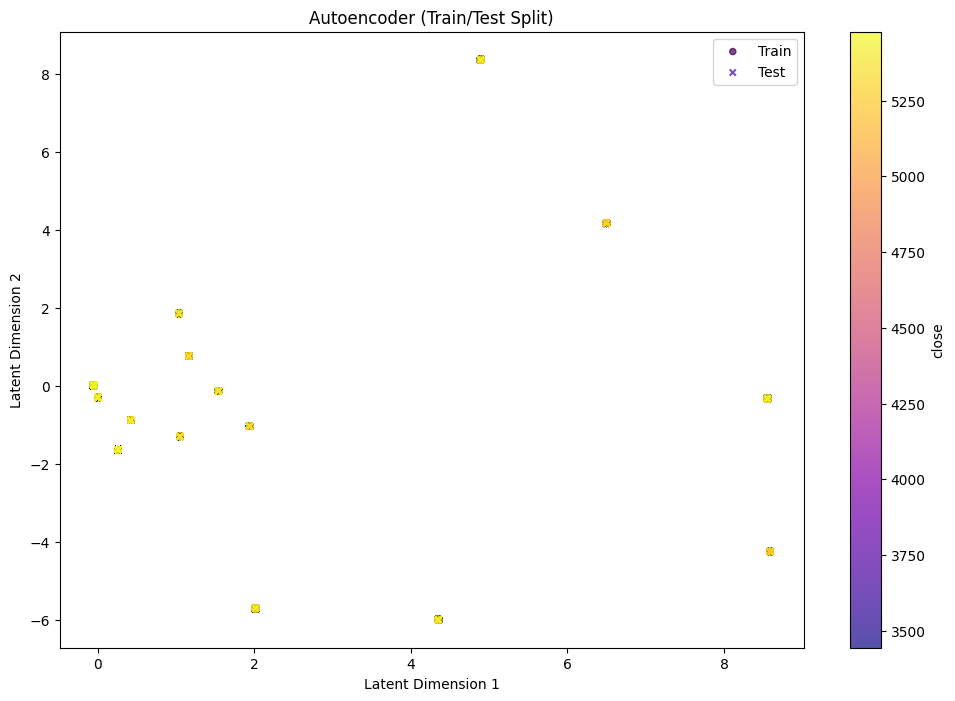

In [11]:
autoencoder.plot_training_history()
autoencoder.plot_latent_space(labels_data_with_latent, color_by='close')

In [12]:
df = labels_data_with_latent[['close', 'latent_dim_1', 'latent_dim_2']]

In [13]:
print(df.tail())

                       close  latent_dim_1  latent_dim_2
datetime                                                
2025-09-05 16:00:00  5455.01     -0.055083      0.017549
2025-09-05 17:00:00  5474.64      0.257008     -1.632490
2025-09-05 18:00:00  5468.49      0.003075     -0.289931
2025-09-05 19:00:00  5476.84     -0.055083      0.017549
2025-09-05 20:00:00  5477.23     -0.055083      0.017549


In [14]:
close_prices = labels_data_with_latent['close'].values

min_indices = argrelextrema(close_prices, np.less, order=5)[0]

max_indices = argrelextrema(close_prices, np.greater, order=5)[0]

labels_data_with_latent['is_extrema'] = 0
labels_data_with_latent.loc[labels_data_with_latent.index[min_indices], 'is_extrema'] = 1 
labels_data_with_latent.loc[labels_data_with_latent.index[max_indices], 'is_extrema'] = 2  

normal_points = labels_data_with_latent[labels_data_with_latent['is_extrema'] == 0]
minima_latent = labels_data_with_latent[labels_data_with_latent['is_extrema'] == 1]
maxima_latent = labels_data_with_latent[labels_data_with_latent['is_extrema'] == 2]

for extrema_type, data, label in [
    (0, normal_points, 'Normal Points'),
    (1, minima_latent, 'Minima (Buy)'),
    (2, maxima_latent, 'Maxima (Sell)')
]:
    
    print(f"\n {label} (n={len(data)}):")
    print(f"Latent Dim 1: {data['latent_dim_1'].mean():.4f} ± {data['latent_dim_1'].std():.4f}")
    print(f"Latent Dim 2: {data['latent_dim_2'].mean():.4f} ± {data['latent_dim_2'].std():.4f}")


 Normal Points (n=33477):
Latent Dim 1: 0.4437 ± 1.3540
Latent Dim 2: -0.8525 ± 1.6214

 Minima (Buy) (n=2385):
Latent Dim 1: 1.3136 ± 0.2280
Latent Dim 2: 0.6281 ± 0.8358

 Maxima (Sell) (n=2354):
Latent Dim 1: 7.0436 ± 1.5423
Latent Dim 2: 3.1604 ± 3.6218


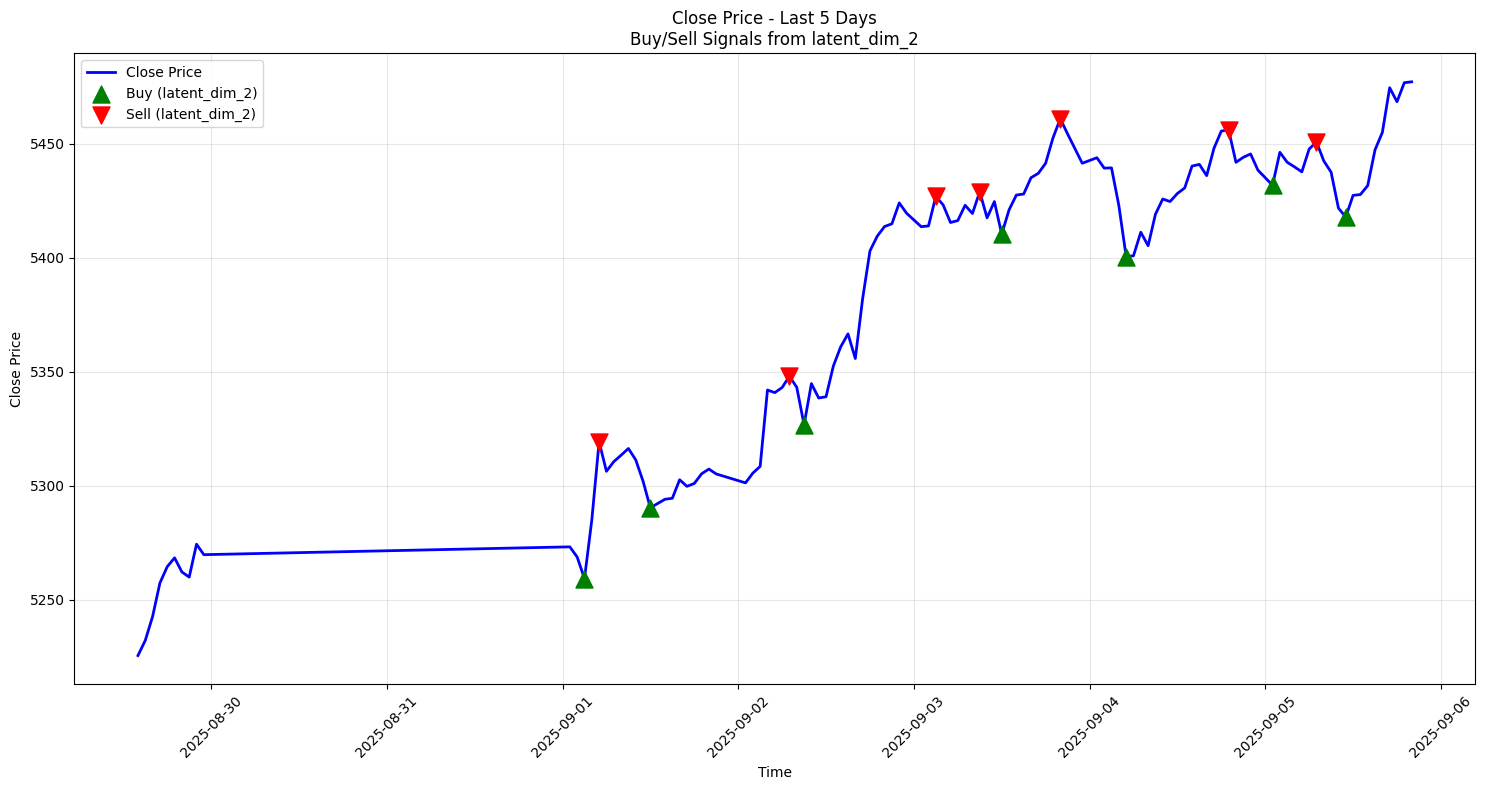

Buy signals:7
Sell signals:7
Hold signals:106


In [ ]:
def auto_signal(latent_1, latent_2):
    buy_zone_l1 = (
        minima_latent['latent_dim_1'].mean() - 1.5 * minima_latent['latent_dim_1'].std(),
        minima_latent['latent_dim_1'].mean() + 1.5 * minima_latent['latent_dim_1'].std()
    )

    buy_zone_l2 = (
        minima_latent['latent_dim_2'].mean() - 1.5 * minima_latent['latent_dim_2'].std(),
        minima_latent['latent_dim_2'].mean() + 1.5 * minima_latent['latent_dim_2'].std()
    )

    sell_zone_l1 = (
        maxima_latent['latent_dim_1'].mean() - 1.5 * maxima_latent['latent_dim_1'].std(),
        maxima_latent['latent_dim_1'].mean() + 1.5 * maxima_latent['latent_dim_1'].std()
    )

    sell_zone_l2 = (
        maxima_latent['latent_dim_2'].mean() - 1.5 * maxima_latent['latent_dim_2'].std(),
        maxima_latent['latent_dim_2'].mean() + 1.5 * maxima_latent['latent_dim_2'].std()
    )
    
    if (sell_zone_l1[0] <= latent_1 <= sell_zone_l1[1] and sell_zone_l2[0] <= latent_2 <= sell_zone_l2[1]):
        return 'sell'
    elif (buy_zone_l1[0] <= latent_1 <= buy_zone_l1[1] and buy_zone_l2[0] <= latent_2 <= buy_zone_l2[1]):
        return 'buy'
    else:
        return 'hold'

last_5_days = labels_data_with_latent.tail(24 * 5)
last_5_days['signal'] = last_5_days.apply(
    lambda row: auto_signal(row['latent_dim_1'], row['latent_dim_2']), axis=1
)

plt.figure(figsize=(15, 8))
plt.plot(
    last_5_days.index, 
    last_5_days['close'], 
    linewidth=2, 
    label='Close Price',
    color='blue'
)

buy_signals_1 = last_5_days[last_5_days['signal'] == 'buy']
plt.scatter(
    buy_signals_1.index, 
    buy_signals_1['close'], 
    color='green', 
    marker='^', 
    s=150, 
    label='Buy (latent_dim_1)',
    zorder=5
)

sell_signals_1 = last_5_days[last_5_days['signal'] == 'sell']
plt.scatter(
    sell_signals_1.index,
    sell_signals_1['close'], 
    color='red',
    marker='v', 
    s=150,
    label='Sell (latent_dim_1)',
    zorder=5
)

plt.title('Close Price - Last 5 Days\nBuy/Sell Signals from latent_dim_1')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(
    last_5_days.index,
    last_5_days['close'],
    linewidth=2,
    label='Close Price',
    color='blue'
)

buy_signals_2 = last_5_days[last_5_days['signal'] == 'buy']
plt.scatter(
    buy_signals_2.index,        
    buy_signals_2['close'], 
    color='green',
    marker='^', 
    s=150, 
    label='Buy (latent_dim_2)', 
    zorder=5
)

sell_signals_2 = last_5_days[last_5_days['signal'] == 'sell']
plt.scatter(
    sell_signals_2.index, 
    sell_signals_2['close'], 
    color='red',
    marker='v',
    s=150,
    label='Sell (latent_dim_2)',
    zorder=5
)

plt.title('Close Price - Last 5 Days\nBuy/Sell Signals from latent_dim_2')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


print(f"Buy signals:{len(buy_signals_1)}")
print(f"Sell signals:{len(sell_signals_1)}")
print(f"Hold signals:{len(last_5_days) - len(buy_signals_1) - len(sell_signals_1)}")